### **Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from math import sqrt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

## **1. For your dataset, each example is a raw text. In this step, we will extract features from the raw texts. You have to create an r × c binary feature matrix M where r is the number of examples and c is the size of the vocabulary consisting of distinct words present in the dataset. Each row corresponds to an example of the dataset and each column corresponds to a word in the vocabulary. Mij = 1 if and only if the j-th word is present in the text of the i example.**

## **1a) Use only the train split (train.csv) of the dataset for your experiment. Which mean you have to create the feature matrix M from train.csv only.**

## **1b) To read data from train.csv, you can use the python package pandas. Use the function pandas.read csv() to read the data.**

### **Function to read the dataset**

In [2]:
def read_data():
    '''
        reads the dataset and returns a dataframe containing the required columns
    '''
    df = pd.read_csv('train.csv')

    cols = ['id', 'label', 'tweet']
    df.drop(cols[0], inplace=True, axis=1) # drop the id column, since it is not required for classification

    return df

df = read_data()

## **1c) Since each example is a raw text, split the text into words (this step is called tokenization). You can use the python ‘re’ package for this. Use the function re.findall(“[a-z0-9]+”, text.tolower()) to split the texts into words.**

## **1d) Once you have splitted the texts into words, remove all the uninformative words (also referred to stopwords) like article, prepositions, verbs etc. You can find a list of stopwords at https://gist.github.com/sebleier/554280.** 

### **Function to perform tokenization and uninformative word removal from dataset**

In [3]:
def process_data(df):
    '''
        returns the tweets and labels as a list of list and also the vocabulary of the dataset
    '''
    data = []
    vocab = dict()

    # list of stopwords from - https://gist.github.com/sebleier/554280
    stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])
    
    cols = ['label', 'tweet']
    index = 0

    for i in range(len(df)):
        label = df.loc[i, cols[0]]
        text = df.loc[i, cols[1]]

        tokens = re.findall("[a-z0-9]+", text.lower())                  # peform tokenization to split the text into words
        tokens = [token for token in tokens if token not in stopwords]  # remove all the uninformative words(stopword removal)

        for token in tokens:
            if token not in vocab:
                vocab[token] = index                                    # add the new token in the vocabulary
                index += 1
        
        data.append([tokens, label])
    
    return data, vocab

data, vocabulary = process_data(df)

## **1e) You may find the matrix M to be very large to fit into the memory. In that case, you can use sparse representation of matrix. You can use either of scipy.sparse.lil matrix or scipy.sparse.csr matrix which ever you find more useful.**

### **Function to create the Feature Matrix**

In [20]:
def create_feature_matrix(data, vocab):
    rows = len(data)
    columns = len(vocab)

    # create a numpy array as the feature matrix
    M = np.zeros((rows, columns), dtype='bool')
    row = 0

    for tokens, _ in data:
        for token in tokens:
            index = vocab[token]
            M[row, index] = True                    # set the feature matrix as 1(True) where the tokens are present
        row += 1

    M = csr_matrix(M) # convert the numpy array to CSR Matrix
    
    return M

X = create_feature_matrix(data, vocabulary)
y = df['label']

## **2. Randomly split the feature matrix into train split and test split with 70-30 ratio. Train a Naive Bayes classifier on the train split. Compute and report the accuracy of the classifier on the test split.**

### **Randomly splitting the data into train and test**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=27)

y_train.index = [i for i in range(len(y_train))]
y_test.index = [i for i in range(len(y_test))]

### **Naive Bayes Classifier**

In [21]:
class NaiveBayes():
    def __init__(self):
        self.labels = []
        self.label_probs = dict()
        self.cond_probs = dict()

    def fit(self, X, y):
        # check if the number of data points is equal to the number of labels
        assert X.shape[0] == len(y)

        # get the list of labels
        self.labels = list(y.unique())
        vocab_size = X.shape[1]

        for label in self.labels:
            y_label = y[y == label]
            prob = len(y_label) / len(y)
            self.label_probs[label] = prob

            indices = list(y_label.index)
            X_label = X[indices]

            self.cond_probs[label] = []
            rows = len(indices)

            # calculate the posterior probabilities for all the attributes for a given label
            for i in range(vocab_size):
                prob = X_label[:, i].count_nonzero() / rows
                self.cond_probs[label].append(prob)

    def predict(self, X):
        vocab_size = X.shape[1]
        prediction_label = self.labels[0]
        max_prob = 0

        X = X.toarray()
        X = list(X[0])

        for label in self.labels:
            prob = self.label_probs[label]

            # calculate the posterior probabilities for all the attributes in the new data point
            for i in range(vocab_size):
                if X[i]:
                    prob *= self.cond_probs[label][i]
                else:
                    prob *= (1 - self.cond_probs[label][i])

            # update the prediction label if the posterior probability is more
            if prob > max_prob:
                max_prob = prob
                prediction_label = label
        
        return prediction_label

### **Training a Naive Bayes Classifier on the train split**

In [8]:
model = NaiveBayes()

model.fit(X_train, y_train)

### **Calculate the Accuracy on the Train Split**

In [9]:
train_correct = 0
train_total = len(y_train)

for i in range(train_total):
    prediction = model.predict(X_train[i])
    if prediction == y_train[i]:
        train_correct += 1
    
train_accuracy = (train_correct/train_total)*100
print("Train Accuracy of Naive Bayes Classifier:", round(train_accuracy, 2))

Train Accuracy of Naive Bayes Classifier: 99.34


### **Calculate the Accuracy on the Test Split**

In [10]:
test_correct = 0
test_total = len(y_test)

for i in range(test_total):
    prediction = model.predict(X_test[i])
    if prediction == y_test[i]:
        test_correct += 1
    
test_accuracy = (test_correct/test_total)*100
print("Test Accuracy of Naive Bayes Classifier:", round(test_accuracy, 2))

Test Accuracy of Naive Bayes Classifier: 95.0


## **3. Train a Naive Bayes classifier using Laplace correction on the same train split and report the accuracy on the test split.**

### **Naive Bayes classifier using Laplace Correction**

In [11]:
class NaiveBayesLaplaceCorrection():
    def __init__(self):
        self.labels = []
        self.label_probs = dict()
        self.cond_probs = dict()
        self.alpha = 1

    def fit(self, X, y):
        # check if the number of data points is equal to the number of labels
        assert X.shape[0] == len(y)

        self.labels = list(y.unique())
        vocab_size = X.shape[1]

        for label in self.labels:
            y_label = y[y == label]
            prob = len(y_label) / len(y)
            self.label_probs[label] = prob

            indices = list(y_label.index)
            X_label = X[indices]

            self.cond_probs[label] = []
            rows = len(indices)
            
            # calculate the posterior probabilities for all the attributes for a given label using laplace correction
            for i in range(vocab_size):
                prob = (X_label[:, i].count_nonzero() + self.alpha) / (rows + self.alpha*vocab_size)
                self.cond_probs[label].append(prob)

    def predict(self, X):
        vocab_size = X.shape[1]
        prediction_label = self.labels[0]
        max_prob = 0

        X = X.toarray()
        X = list(X[0])

        for label in self.labels:
            prob = self.label_probs[label]

            # calculate the posterior probabilities for all the attributes in the new data point
            for i in range(vocab_size):
                if X[i]:
                    prob *= self.cond_probs[label][i]
                else:
                    prob *= (1 - self.cond_probs[label][i])

            # update the prediction label if the posterior probability is more
            if prob > max_prob:
                max_prob = prob
                prediction_label = label
        
        return prediction_label

### **Training a Naive Bayes Classifier using Laplace Correction on the Same Train Split**

In [12]:
model_laplace = NaiveBayesLaplaceCorrection()

model_laplace.fit(X_train, y_train)

### **Calculate the Training Accuracy of the model with Laplace Correction**

In [13]:
laplace_train_correct = 0
laplace_train_total = len(y_train)

for i in range(laplace_train_total):
    prediction = model_laplace.predict(X_train[i])
    if prediction == y_train[i]:
        laplace_train_correct += 1
    
laplace_train_accuracy = (laplace_train_correct/laplace_train_total)*100
print("Train Accuracy of Naive Bayes Classifier using Laplace Correction:", round(laplace_train_accuracy, 2))

Train Accuracy of Naive Bayes Classifier using Laplace Correction: 95.17


### **Calculate the Test Accuracy of the model with Laplace Correction**

In [14]:
laplace_test_correct = 0
laplace_test_total = len(y_test)

for i in range(laplace_test_total):
    prediction = model_laplace.predict(X_test[i])
    if prediction == y_test[i]:
        laplace_test_correct += 1
    
laplace_test_accuracy = (laplace_test_correct/laplace_test_total)*100
print("Test Accuracy of Naive Bayes Classifier using Laplace Correction:", round(laplace_test_accuracy, 2))

Test Accuracy of Naive Bayes Classifier using Laplace Correction: 94.55


## **4. A report explaining the implementation and analysis of the results by providing the 95% confidence interval of the accuracy, precision, f-score, sensitivity and specificity for questions 2 and 3.**

### **(Question 2) 95% Confidence Interval of the Accuracy, Precision, F-score, Sensitivity, Specificity of Naive Bayes Classifier on the Test Split**

In [15]:
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0
accuracy = 0
const = 1.96                       # for 95% confidence interval const = 1.96
prediction_labels = []

test_total = len(y_test)

for i in range(test_total):
    prediction = model.predict(X_test[i])
    prediction_labels.append(prediction)
    if y_test[i] == 1:
        if prediction == 1:
            true_positive += 1
            accuracy += 1
        else:
            false_negative += 1
    else:
        if prediction == 1:
            false_positive += 1
        else:
            true_negative += 1
            accuracy += 1

precision = true_positive / (true_positive + false_positive)
sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)
f_score = (2 * precision * sensitivity) / (precision + sensitivity)
accuracy = accuracy / test_total
temp = const * sqrt( (accuracy * (1 - accuracy)) / test_total)
min_interval = max(0, accuracy - temp)
max_interval = min(accuracy + temp, 1)

print("Test 95% Confidence Interval of Naive Bayes Classifier: [" + str(round(min_interval, 4)) + ", " + str(round(max_interval, 4)) + "]")
print("Test Precision of Naive Bayes Classifier:", round(precision, 2))
print("Test F-score of Naive Bayes Classifier:", round(f_score, 2))
print("Test Sensitivity of Naive Bayes Classifier:", round(sensitivity, 2))
print("Test Specificity of Naive Bayes Classifier:", round(specificity, 2))

Test 95% Confidence Interval of Naive Bayes Classifier: [0.9457, 0.9544]
Test Precision of Naive Bayes Classifier: 0.85
Test F-score of Naive Bayes Classifier: 0.5
Test Sensitivity of Naive Bayes Classifier: 0.35
Test Specificity of Naive Bayes Classifier: 1.0


### **(Question 3) 95% Confidence Interval of the Accuracy, Precision, F-score, Sensitivity, Specificity of Naive Bayes Classifier using Laplace Correction on the Test Split**

In [16]:
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0
accuracy = 0
const = 1.96                       # for 95% confidence interval const = 1.96
laplace_prediction_labels = []

test_total = len(y_test)

for i in range(test_total):
    prediction = model_laplace.predict(X_test[i])
    laplace_prediction_labels.append(prediction)
    if y_test[i] == 1:
        if prediction == 1:
            true_positive += 1
            accuracy += 1
        else:
            false_negative += 1
    else:
        if prediction == 1:
            false_positive += 1
        else:
            true_negative += 1
            accuracy += 1

precision = true_positive / (true_positive + false_positive)
sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)
f_score = (2 * precision * sensitivity) / (precision + sensitivity)
accuracy = accuracy / test_total
temp = const * sqrt( (accuracy * (1 - accuracy)) / test_total)
min_interval = max(0, accuracy - temp)
max_interval = min(accuracy + temp, 1)

print("Test 95% Confidence Interval of Naive Bayes Classifier using Laplace Correction: [" + str(round(min_interval, 4)) + ", " + str(round(max_interval, 4)) + "]")
print("Test Precision of Naive Bayes Classifier using Laplace Correction:", round(precision, 2))
print("Test F-score of Naive Bayes Classifier using Laplace Correction:", round(f_score, 2))
print("Test Sensitivity of Naive Bayes Classifier using Laplace Correction:", round(sensitivity, 2))
print("Test Specificity of Naive Bayes Classifier using Laplace Correction:", round(specificity, 2))

Test 95% Confidence Interval of Naive Bayes Classifier using Laplace Correction: [0.9409, 0.95]
Test Precision of Naive Bayes Classifier using Laplace Correction: 0.89
Test F-score of Naive Bayes Classifier using Laplace Correction: 0.4
Test Sensitivity of Naive Bayes Classifier using Laplace Correction: 0.25
Test Specificity of Naive Bayes Classifier using Laplace Correction: 1.0


# **For Report - Confusion Matrix**

In [17]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Text(80.90000000000006, 0.5, 'Predicted Label')

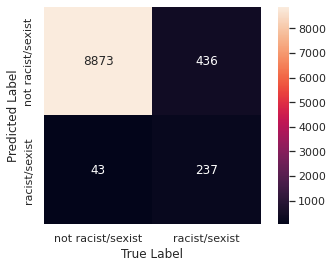

In [18]:
mat = confusion_matrix(y_test, prediction_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', xticklabels=['not racist/sexist', 'racist/sexist'], yticklabels=['not racist/sexist', 'racist/sexist'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

Text(80.90000000000006, 0.5, 'Predicted Label')

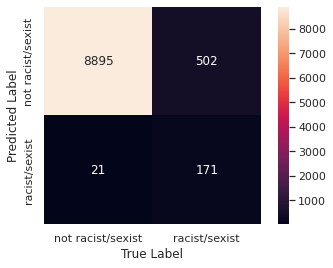

In [19]:
mat = confusion_matrix(y_test, laplace_prediction_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', xticklabels=['not racist/sexist', 'racist/sexist'], yticklabels=['not racist/sexist', 'racist/sexist'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')